In [22]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy.random as rnd
from scipy.stats import chi
import lmfit
from lmfit import minimize, Parameters

### Parameters & class definition

In [23]:
width_LG = 45/np.sqrt(2)   #µm

k_B = 1.38*10**-23   #µm^2 Kg ms^-2 µK^-1

m_Rb = 85*1.6*10**-27    #kg

h = 6.62*10**-25   # µm^2 kg ms^-1

omega_l = 2*np.pi*(3*10**5)/(1064*10**-9)  #ms^-1

m_e = 9.1*10**-31   #kg

beta = (1/137)* h /(m_e * omega_l**2)   #proportionality factor b/w energy & intensity, µm^2 ms

def LG(x, w, P):      #J ms^-1 µm^-2
    return P*(4*(x**2)/(np.pi*w**4)*np.exp(-2*x**2/w**2))

def E(x, w, P):       #J
    return LG(x, w, P)*beta

def dLG(x, w, P):     #J ms^-1 µm^-3
    return P*(8*x/(np.pi*w**4)*np.exp(-2*x**2/w**2))*(1-2*x**2/w**2)

def dE(x, w, P):      # J µm^-1
    return dLG(x, w, P)*beta

def non_lin(x):
    return 0.503 + 0.507*np.sin(np.pi*(x-0.5656)/0.9841)

class Atoms(object):
    
    def __init__(self, n_atoms, temp, w_g, x_0, p_0, freq, A, nonlin):
        """Create an atom"""
        
        self.n_atoms = n_atoms
        
        self.temperature = temp
        
        self.nonlinearity = nonlin
        
        self.velocities = np.random.normal(0, np.sqrt(k_B*temp/m_Rb), n_atoms)    #in µm ms^-1
          
        self.kin = (m_Rb/k_B)*np.sum(self.velocities**2)      #in µK 
        
        self.x_positions = np.random.normal(x_0, w_g/2, n_atoms)     #in µm
        
        self.power_init = p_0
        
        self.power = p_0
        
        self.y_positions = E(self.x_positions, width_LG, self.power)/(k_B*10**-6)   #kB in m^2 Kg s^-2 µK^-1
        
        self.freq = freq
        
        self.amp = A/100
        
        self.forces = -dE(self.x_positions, width_LG, self.power)    #J µm^-1
        
        self.time = 0

            
    def step(self, dt):
        self.time += dt
        self.x_positions += dt * self.velocities
        self.y_positions = E(self.x_positions, width_LG, self.power)/(k_B*10**-6)
        self.velocities += dt * (10**6)*self.forces/m_Rb     #10**6 to convert J=kg*m^2*s^-2 to kg*µm^2*ms^-2
        self.kin = (m_Rb/k_B)*np.sum(self.velocities**2)       #in µK
        self.forces = -dE(self.x_positions, width_LG, self.power)
        if self.nonlinearity==False:
            self.power = self.power_init*(1-self.amp + self.amp*np.cos(2*np.pi*self.freq*self.time/2)**2)
        else:
            self.power = self.power_init*non_lin(1-self.amp + self.amp*np.cos(2*np.pi*self.freq*self.time/2)**2)

### Running a simulation

<IPython.core.display.Javascript object>


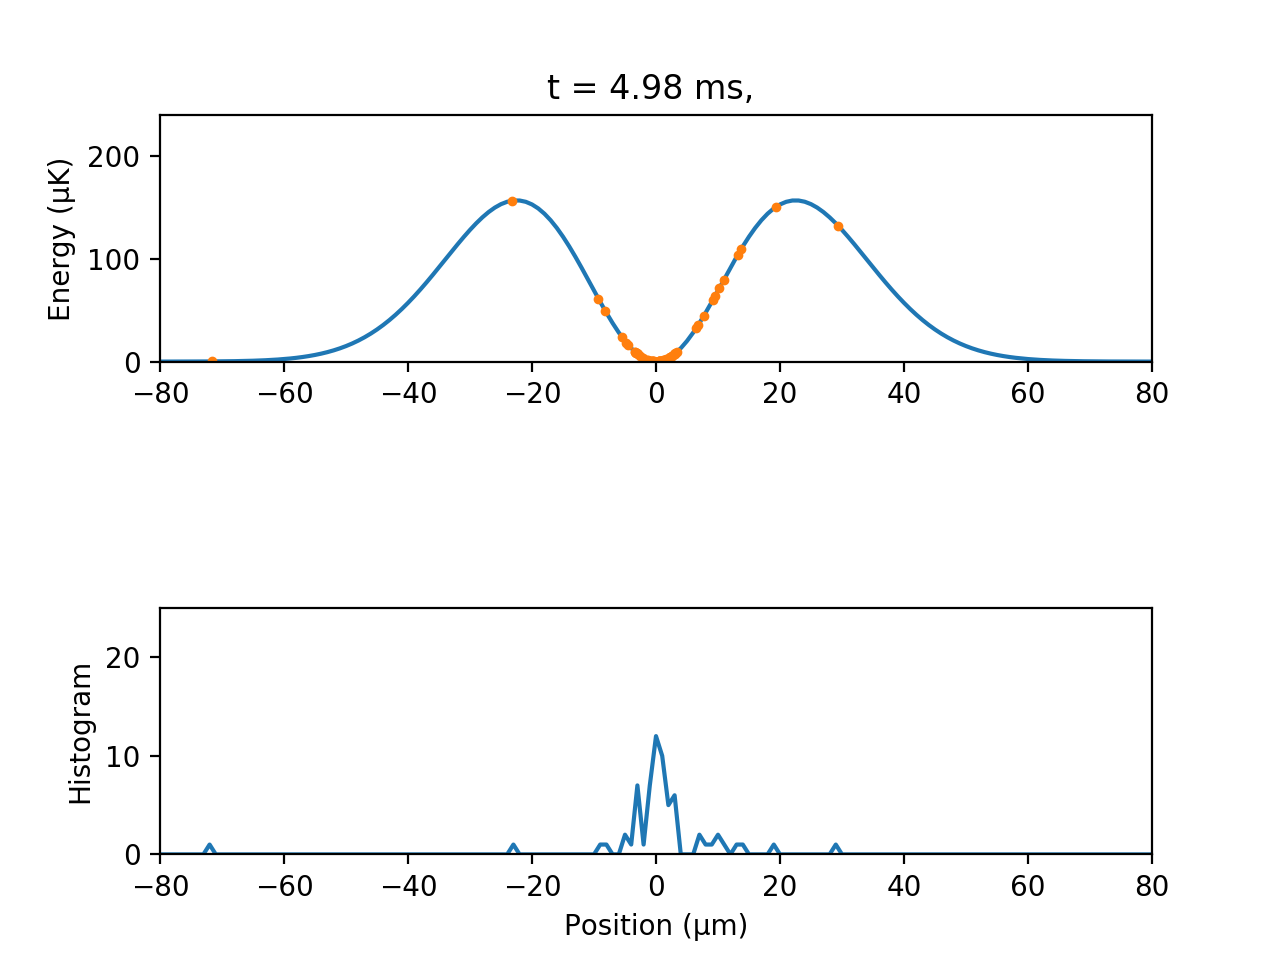

In [15]:
N_at = 100

temperature =  5      #µK

width_blue = 10   #µm

init_offset = 0   #µm

P_0 = 5.65*10**-3    #J ms^-1

freq_modulation = 3.    #kHz

amp_modulation = 50   # in % of power

X = np.linspace(-80,80,161)
x = np.linspace(-80, 80, 161)

atoms = Atoms(N_at,  temperature, width_blue, init_offset, P_0, freq_modulation, amp_modulation, False)

def fit_gauss(pos, counts):  #fitting routine, exponential decay
    params = Parameters()
    params.add('x_0', value= 0, vary=True, min=-80., max=80.)
    params.add('A', value= 10000, vary=True)
    params.add('w', value = 10, vary = True, min = 0., max = 100.)

    result_fit = lmfit.minimize(fit_fc_gauss, params, args=(pos, counts))
    width = result_fit.params['w'].value
    center = result_fit.params['x_0'].value
    amp = result_fit.params['A'].value
    return width, center, amp

def fit_fc_gauss(params, x, data):   #fitting function, exponential decay
    x_0 = params['x_0'].value
    A = params['A'].value
    sigma = params['w'].value
    model = A/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-x_0)**2/(2*sigma**2))
    return (data - model)

fig = plt.figure()
fig.subplots_adjust(hspace = 1)
fig.subplots_adjust(wspace = 0.5)
ax = fig.add_subplot(211)
trap, = ax.plot([], [])
line, = ax.plot([], [], '.', ms=5)
ax.set_xlim(-80, 80)
ax.set_ylim(0, 1.5*np.max(E(X, width_LG, atoms.power)/(k_B*10**-6)))
#plt.xlabel('Position (µm)')
plt.ylabel('Energy (µK)')

ax2 = fig.add_subplot(212)
hist, = ax2.plot([], [])
fit, = ax2.plot([], [])
plt.xlabel('Position (µm)')
plt.ylabel('Histogram')
ax2.set_ylim(0, 25)
ax2.set_xlim(-80, 80)

#ax3 = fig.add_subplot(413)
#centers = []
#center, = ax3.plot([],[])
#plt.ylabel('Center of cloud')
#ax3.set_xlim(0, 10)
#ax3.set_ylim(-15, 15)

#ax4 = fig.add_subplot(414)
#waists = []
#waist, = ax4.plot([],[])
#plt.ylabel('Waist of cloud')
#ax4.set_xlim(0, 10)
#ax4.set_ylim(0, 20)


def animate(i):
    
    atoms.step(0.001)   #time step, in ms; 1 µs steps

    trap.set_data(X, E(X, width_LG, atoms.power)/(k_B*10**-6))
    line.set_data(atoms.x_positions, atoms.y_positions)
    
    histogram = np.histogram(atoms.x_positions, 161, range=(-80,80))[0]
    hist.set_data(x, histogram)
    
    #f = fit_gauss(x, histogram)
    #fit.set_data(x, f[2]/(f[0]*np.sqrt(2*np.pi)) * np.exp(-(x-f[1])**2/(2*f[0]**2)))
    
    ax.set_title('t = ' + str(np.round(atoms.time, 2)) + ' ms, ')
    
    #centers.append(np.mean([x for x in atoms.x_positions if x**2 < 30**2]))
    #center.set_data(np.linspace(0.,np.shape(centers)[0]*0.001, np.shape(centers)[0]) , centers)
    
    #waists.append(np.std([x for x in atoms.x_positions if x**2 < 30**2]))
    #waist.set_data(np.linspace(0.,np.shape(centers)[0]*0.001, np.shape(centers)[0]) , waists)
    
    return line, trap, #center, waist

anim = animation.FuncAnimation(fig, animate, interval=2, blit=False)

### Parametric excitation scans

In [24]:
freqs = np.linspace(0.0, 5, 51)

def param_exc(tot_time, N, temp, w_b, P_0, mod, nonlinearity):

    ejection = np.zeros(51)
    kin_energies = np.zeros(51)
    size = np.zeros(51)
    
    for i in range(51):
        freq = freqs[i]

        atoms = Atoms(N, temp, w_b, 0, P_0, freq, mod, nonlinearity)

        for j in range(int(tot_time/0.0005)):
            atoms.step(0.0005)

        for k in range(N):
            if(atoms.x_positions[k]**2 > width_LG*np.sqrt(2)**2):
                ejection[i] +=1
        ejection[i] = ejection[i]/N
        kin_energies[i] = atoms.kin/N
        size[i] = np.std(atoms.x_positions)
                

    #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5))
    #plt.title('Parametric excitation, '+ str(mod) + '% modulation')
    #ax1.plot(freqs, ejection)
    #ax1.set_ylim(0,1)
    #plt.ylabel('Ejection')
    #ax1.set_title('Param. exc. - ejection' + str(amp_modulation) + '% modulation')
    

    #ax2.plot(freqs, kin_energies)
    #plt.ylabel('Ec (µK)')
    #ax2.set_title('Param. exc. - kinetic energy' + str(amp_modulation) + '% modulation')
    

    #ax3.plot(freqs, size)
    #plt.xlabel('Modulation Frequency (kHz)')
    #plt.ylabel(r'$\sigma_r$ (µm)')
    #ax3.set_title('Param. exc. - size of the cloud' + str(amp_modulation) + '% modulation')
    
   
    return ejection, kin_energies, size

In [27]:
total_time = 5.5

N_at = 1000

temperature =  5  #µK

width_blue = 5    #µm

P_0 = 0.6*5.65*10**-3    #J ms^-1

mods = np.array([50])   # in % of power

fin_lin = np.zeros((mods.size, 3, 51))
fin_non_lin = np.zeros((mods.size, 3, 51))

for i in range(mods.size):
    
    res_lin = param_exc(total_time, N_at, temperature, width_blue, P_0, mods[i], 0)
    fin_lin[i][0] = res_lin[0]
    fin_lin[i][1] = res_lin[1]
    fin_lin[i][2] = res_lin[2]
               

<IPython.core.display.Javascript object>


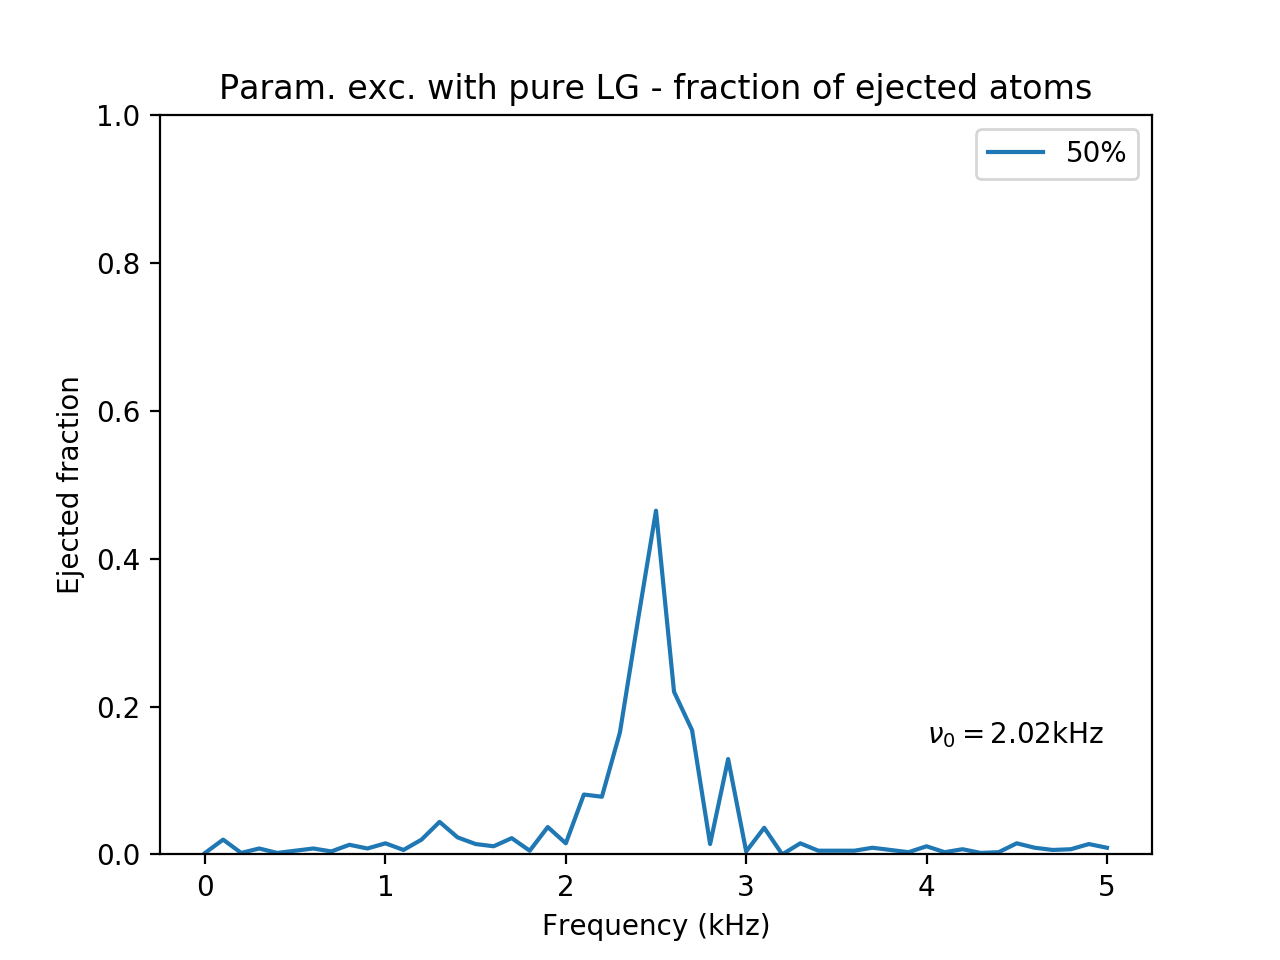

In [28]:
plt.figure()
plt.title('Param. exc. with pure LG - fraction of ejected atoms')
for i in range(mods.size):
    plt.plot(freqs, fin_lin[i,0], label = str(mods[i]) + '%')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Ejected fraction')
plt.ylim(0,1)
plt.text(4, 0.15, r'$\nu_0 = 2.02 $'+'kHz')
plt.legend()
#plt.savefig('paramexc_ejection_power.png', format = 'png', dpi = 1000)

<IPython.core.display.Javascript object>


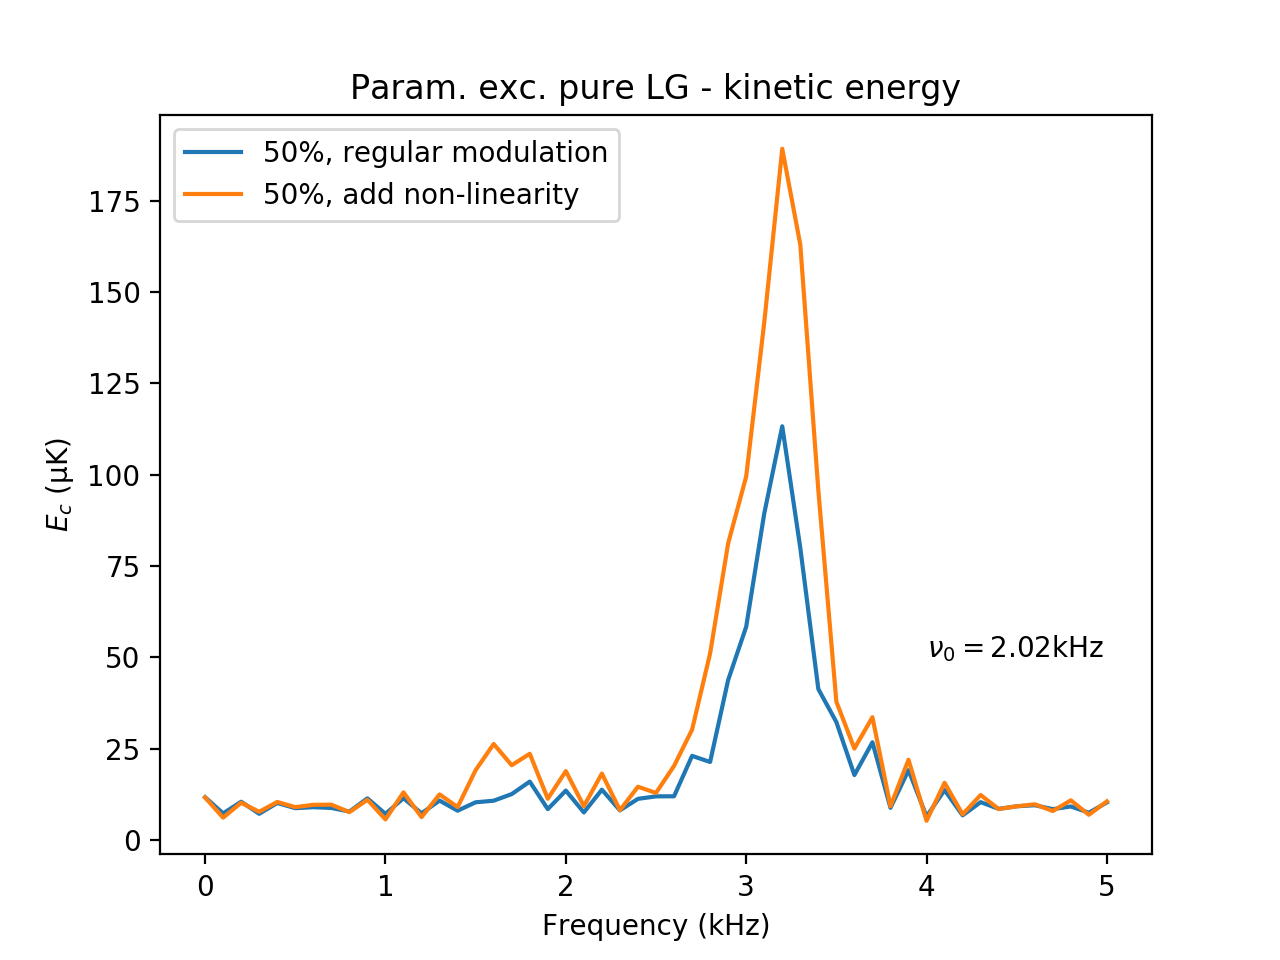

In [21]:
plt.figure()
plt.title('Param. exc. pure LG - kinetic energy')
for i in range(mods.size):
    plt.plot(freqs, fin_lin[i,1], label = str(mods[i]) + '%, regular modulation')
    plt.plot(freqs, fin_non_lin[i,1], label = str(mods[i]) + '%, add non-linearity')
plt.xlabel('Frequency (kHz)')
plt.ylabel(r'$E_c$ (µK)' )
plt.text(4, 50, r'$\nu_0 = 2.02 $'+'kHz')
plt.legend()
plt.savefig('paramexc_LG_comparison_kin.png', format = 'png', dpi = 1000)

<IPython.core.display.Javascript object>


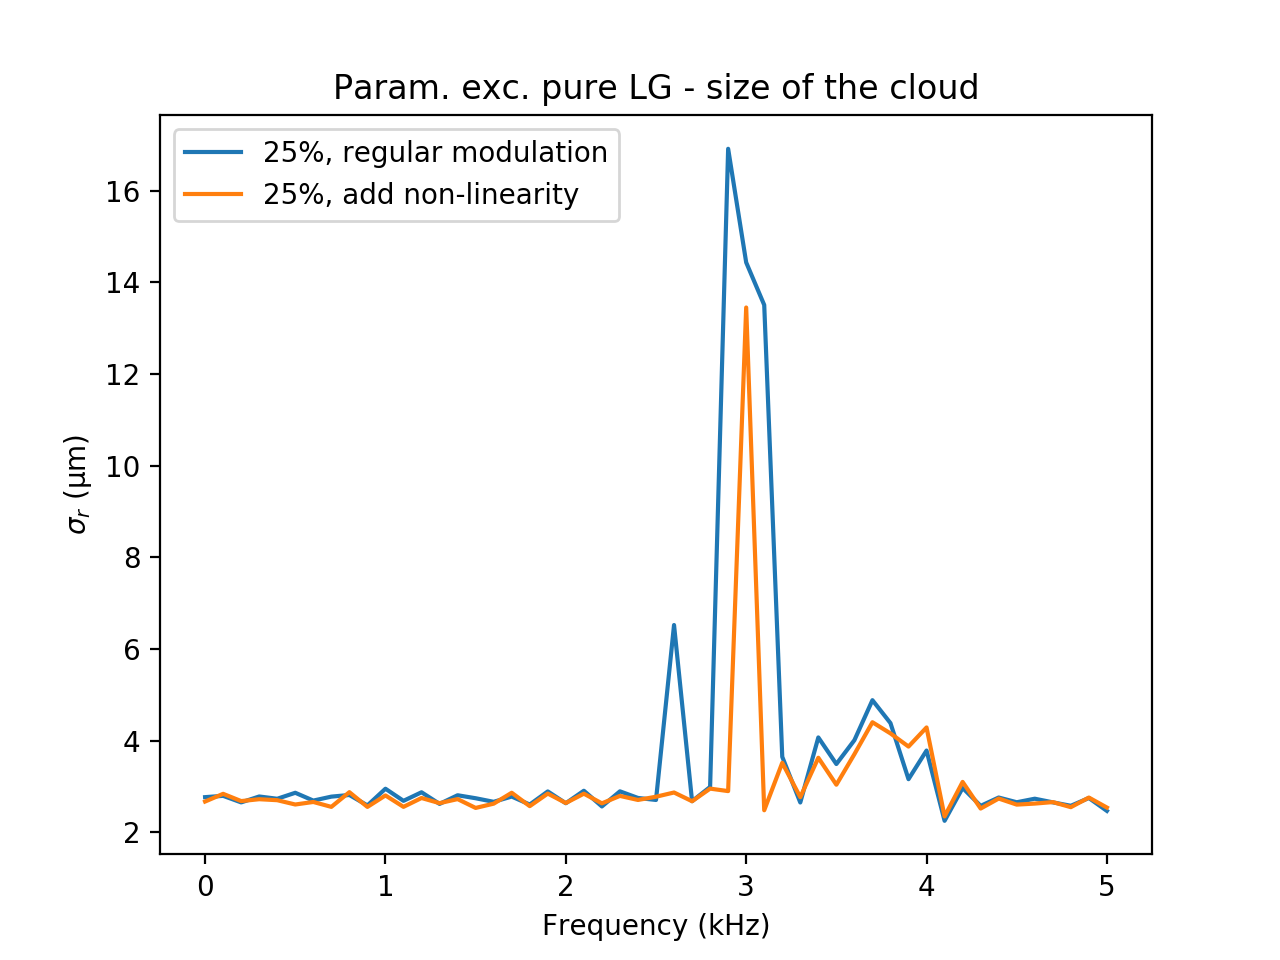

In [10]:
plt.figure()
plt.title('Param. exc. pure LG - size of the cloud')
for i in range(mods.size):
    plt.plot(freqs, fin_lin[i,2], label = str(mods[i]) + '%, regular modulation')
    plt.plot(freqs, fin_non_lin[i,2], label = str(mods[i]) + '%, add non-linearity')
plt.xlabel('Frequency (kHz)')
plt.ylabel(r'$\sigma_r$ (µm)' )
plt.text(4, 100, r'$\nu_0 = 2.02 $'+'kHz')
plt.legend()
plt.savefig('paramexc_LG_comparison_size.png', format = 'png', dpi = 1000)